<a href="https://www.kaggle.com/code/adends/store-sales-forecasting-competition?scriptVersionId=166060316" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [24]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
np.int = int
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.style
import seaborn as sns


import joblib
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.impute import KNNImputer
from skopt.space import Real, Integer
from category_encoders import BinaryEncoder
from sklearn.compose import ColumnTransformer

from xgboost import DMatrix, train


sns.set_style("whitegrid")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/timeseriesxgb/other/1.0/1/model.joblib
/kaggle/input/timeseriesxgb/other/1.1/1/model.joblib
/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


# Exploratory Data Analysis

In [25]:
df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv')
df_test = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df_test['date'] = pd.to_datetime(df_test['date'])
df_test.set_index('date', inplace=True)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3000888 entries, 2013-01-01 to 2017-08-15
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   store_nbr    int64  
 2   family       object 
 3   sales        float64
 4   onpromotion  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [27]:
df.head()

,id,store_nbr,family,sales,onpromotion
date,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0
2013-01-01,1,1,BABY CARE,0.0,0
2013-01-01,2,1,BEAUTY,0.0,0
2013-01-01,3,1,BEVERAGES,0.0,0
2013-01-01,4,1,BOOKS,0.0,0


In [28]:
df.drop('id', axis=1, inplace=True)

In [29]:
df.isna().sum()

store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

<Axes: title={'center': 'Sales Over Time In Ecuador'}, xlabel='date'>

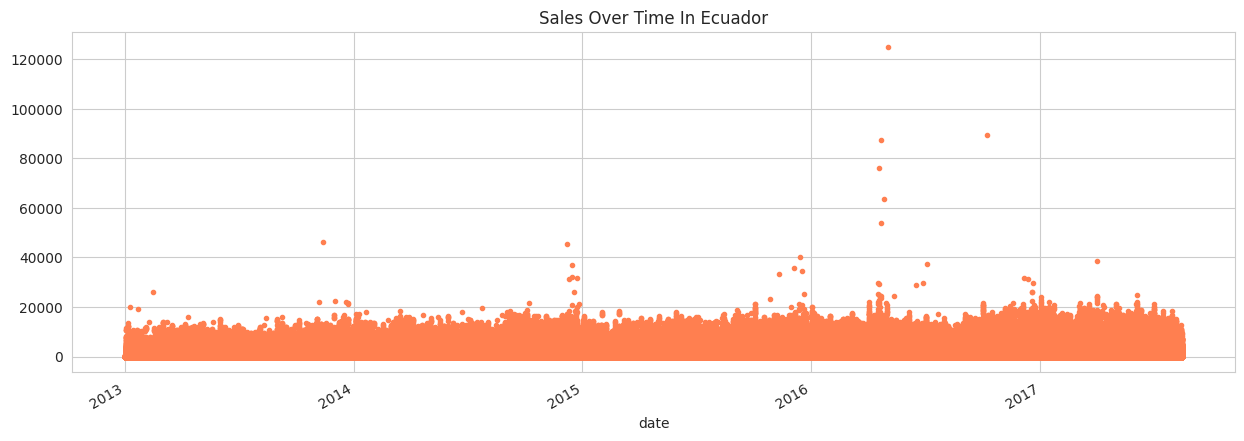

In [30]:
df['sales'].plot(style='.', figsize=(15, 5), color='coral', title='Sales Over Time In Ecuador')

In [31]:
family = set(df['family'].unique())

len(family), family

(33,
 {'AUTOMOTIVE',
  'BABY CARE',
  'BEAUTY',
  'BEVERAGES',
  'BOOKS',
  'BREAD/BAKERY',
  'CELEBRATION',
  'CLEANING',
  'DAIRY',
  'DELI',
  'EGGS',
  'FROZEN FOODS',
  'GROCERY I',
  'GROCERY II',
  'HARDWARE',
  'HOME AND KITCHEN I',
  'HOME AND KITCHEN II',
  'HOME APPLIANCES',
  'HOME CARE',
  'LADIESWEAR',
  'LAWN AND GARDEN',
  'LINGERIE',
  'LIQUOR,WINE,BEER',
  'MAGAZINES',
  'MEATS',
  'PERSONAL CARE',
  'PET SUPPLIES',
  'PLAYERS AND ELECTRONICS',
  'POULTRY',
  'PREPARED FOODS',
  'PRODUCE',
  'SCHOOL AND OFFICE SUPPLIES',
  'SEAFOOD'})

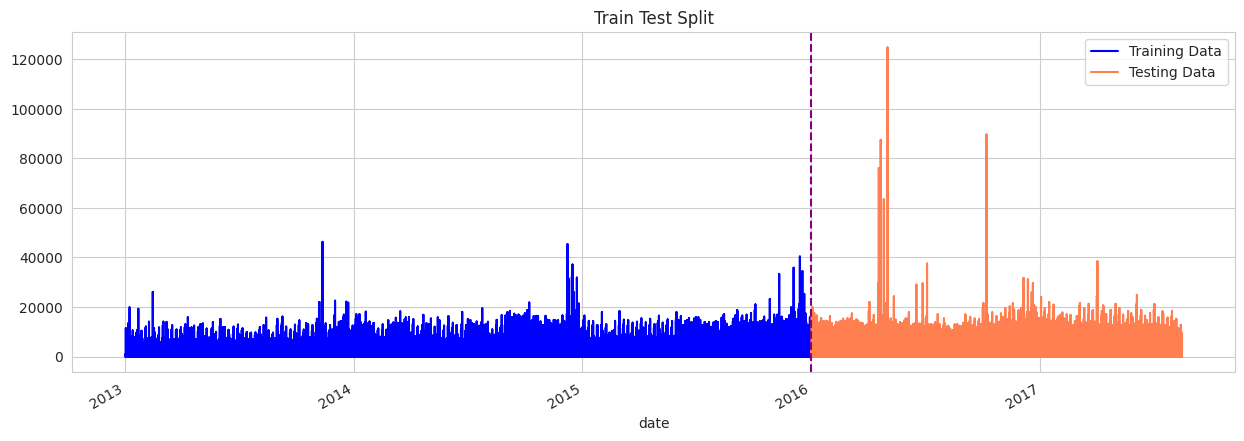

In [32]:
train = df.loc[df.index < '2016-01-01']
test = df.loc[df.index >= '2016-01-01']

fig, ax = plt.subplots(figsize=(15,5))

train['sales'].plot(ax=ax, label='Training', color='blue', title='Train Test Split')
test['sales'].plot(ax=ax, label='Testing', color='coral')

ax.axvline('2016-01-01', color='purple', ls='--')
ax.legend(['Training Data', 'Testing Data'])

plt.show()

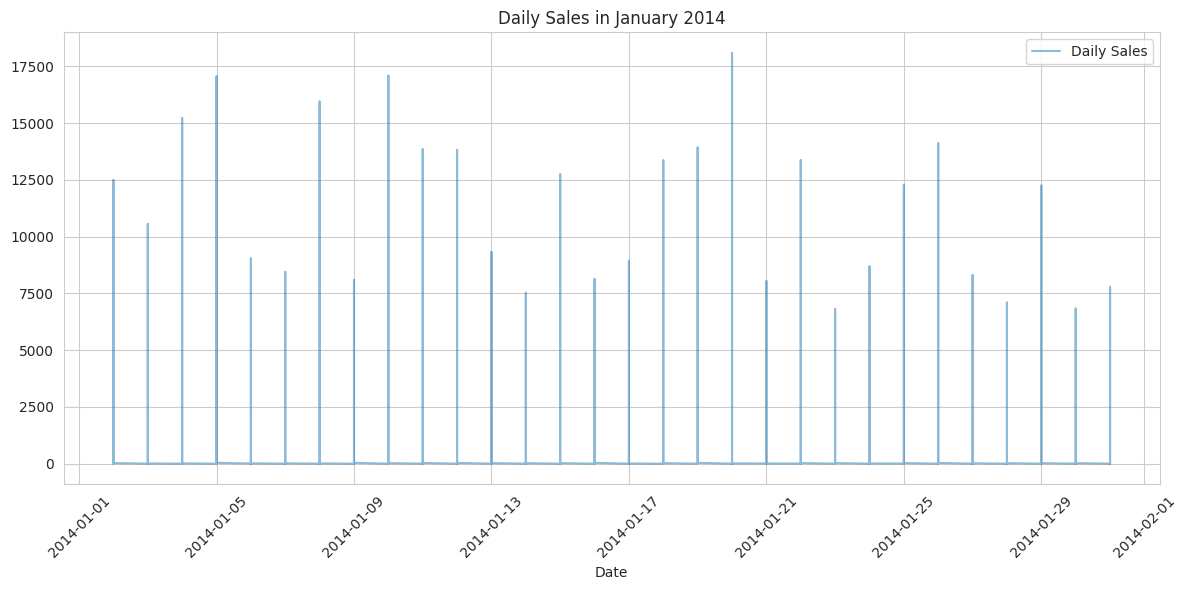

In [33]:
plt.figure(figsize=(12, 6))

plt.plot(df['sales'].loc[(df.index > '2014-01-01') & (df.index < '2014-02-01')], alpha=0.5, label='Daily Sales')

plt.title('Daily Sales in January 2014')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [34]:
def create_date_features(df):
    df=df.copy()
    df['day'] = df.index.day_of_week
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    return df

df = create_date_features(df)
df_test = create_date_features(df_test)

df

,store_nbr,family,sales,onpromotion,day,month,quarter,year
date,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.000,0,1,1,1,2013
2013-01-01,1,BABY CARE,0.000,0,1,1,1,2013
2013-01-01,1,BEAUTY,0.000,0,1,1,1,2013
2013-01-01,1,BEVERAGES,0.000,0,1,1,1,2013
2013-01-01,1,BOOKS,0.000,0,1,1,1,2013
...,...,...,...,...,...,...,...,...
2017-08-15,9,POULTRY,438.133,0,1,8,3,2017
2017-08-15,9,PREPARED FOODS,154.553,1,1,8,3,2017
2017-08-15,9,PRODUCE,2419.729,148,1,8,3,2017


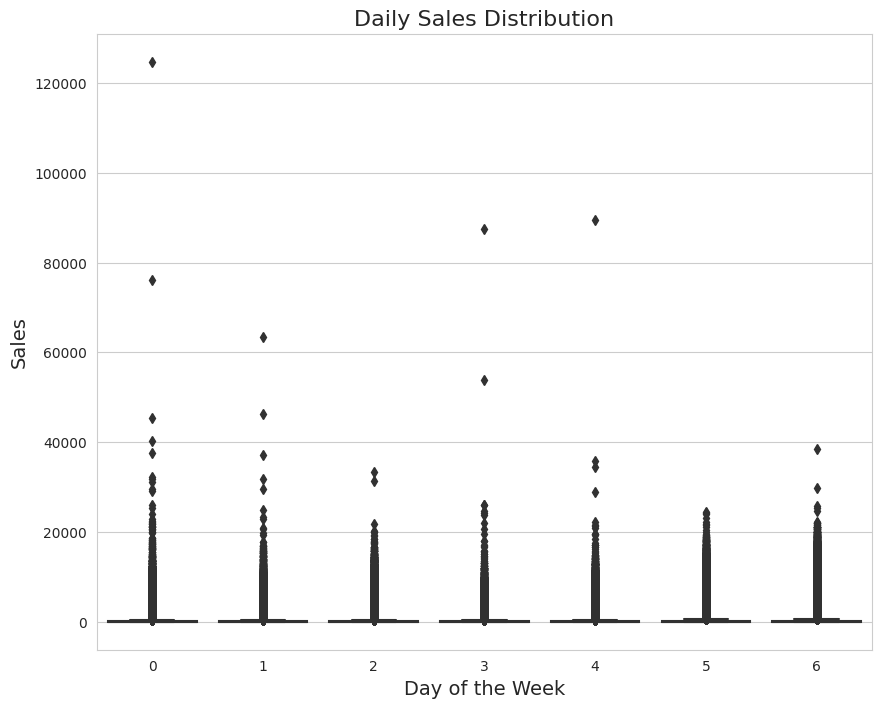

In [35]:
fig, ax = plt.subplots(figsize=(10, 8))


sns.boxplot(data=df[['sales', 'day']], x='day', y='sales', palette='Blues', ax=ax)

ax.set_title('Daily Sales Distribution', fontsize=16)
ax.set_xlabel('Day of the Week', fontsize=14)
ax.set_ylabel('Sales', fontsize=14)

plt.show()

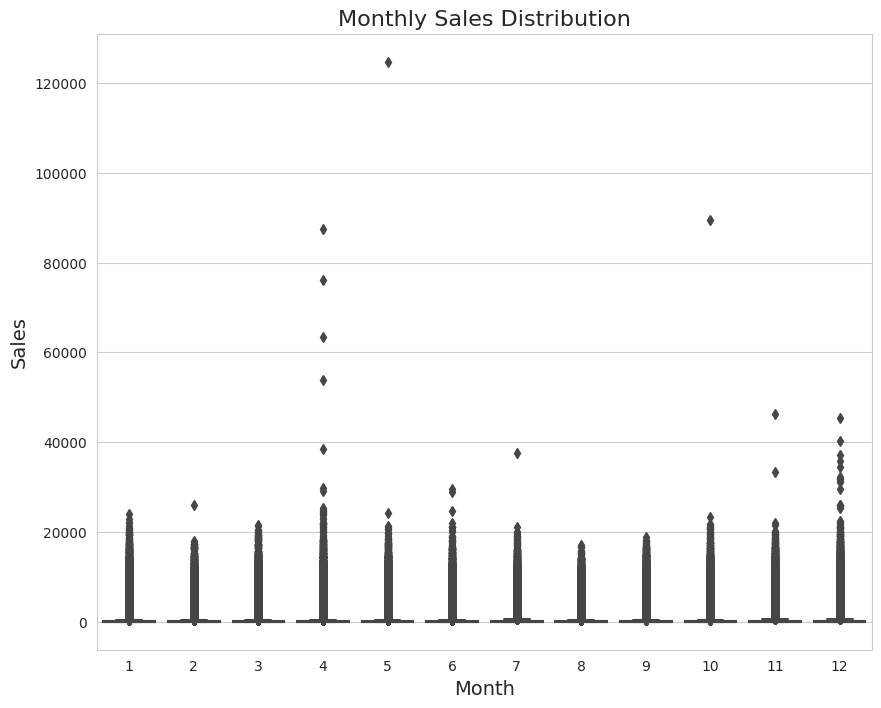

In [36]:
fig, ax = plt.subplots(figsize=(10, 8))


sns.boxplot(data=df[['sales', 'month']], x='month', y='sales', ax=ax)

ax.set
ax.set_title('Monthly Sales Distribution', fontsize=16)
ax.set_xlabel('Month', fontsize=14)
ax.set_ylabel('Sales', fontsize=14)

plt.show()

In [37]:
train, test = create_date_features(train), create_date_features(test)

df.columns

Index(['store_nbr', 'family', 'sales', 'onpromotion', 'day', 'month',
       'quarter', 'year'],
      dtype='object')

In [38]:
FEATURES = ['store_nbr', 'family', 'onpromotion', 'day', 'month', 'quarter', 'year']
TARGET = ['sales']

In [39]:
X_train, y_train = train[FEATURES].copy(), train[TARGET].copy()
X_test, y_test = test[FEATURES].copy(), test[TARGET].copy()

X_train['family'] = X_train['family'].astype('category')
X_test['family'] = X_test['family'].astype('category')

dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

In [40]:
params = {
    'learning_rate': 0.01,
}

config = {  
    'evals': [(dtrain, 'train'), (dtest, 'test')],
    'verbose_eval': 10,
}

model = xgb.train(params, dtrain, **config, num_boost_round=1000)

[0]	train-rmse:954.06231	test-rmse:1317.77041
[10]	train-rmse:887.10508	test-rmse:1238.82175
[20]	train-rmse:827.76610	test-rmse:1163.65965
[30]	train-rmse:775.59453	test-rmse:1096.61695
[40]	train-rmse:729.76211	test-rmse:1036.53880
[50]	train-rmse:689.11136	test-rmse:983.90548
[60]	train-rmse:653.34400	test-rmse:938.09944
[70]	train-rmse:622.20139	test-rmse:897.36615
[80]	train-rmse:593.83227	test-rmse:861.54339
[90]	train-rmse:569.13961	test-rmse:831.47583
[100]	train-rmse:547.95985	test-rmse:804.45735
[110]	train-rmse:528.86065	test-rmse:780.65882
[120]	train-rmse:512.57128	test-rmse:759.31911
[130]	train-rmse:498.04288	test-rmse:741.12114
[140]	train-rmse:485.39168	test-rmse:724.87524
[150]	train-rmse:473.96093	test-rmse:710.47859
[160]	train-rmse:464.04075	test-rmse:698.28959
[170]	train-rmse:454.72780	test-rmse:687.42703
[180]	train-rmse:445.90099	test-rmse:677.63834
[190]	train-rmse:437.89948	test-rmse:669.38076
[200]	train-rmse:431.18406	test-rmse:662.23698
[210]	train-rmse:42

In [41]:
scores = model.get_score()

feature_names = list(scores.keys())
importance_scores = list(scores.values())

In [42]:
feature_importance = pd.DataFrame(data= importance_scores,
                                  index= feature_names,
                                  columns=['Importance'])

feature_importance

,Importance
store_nbr,24330.0
family,15070.0
onpromotion,6730.0
day,5896.0
month,5683.0
year,4194.0


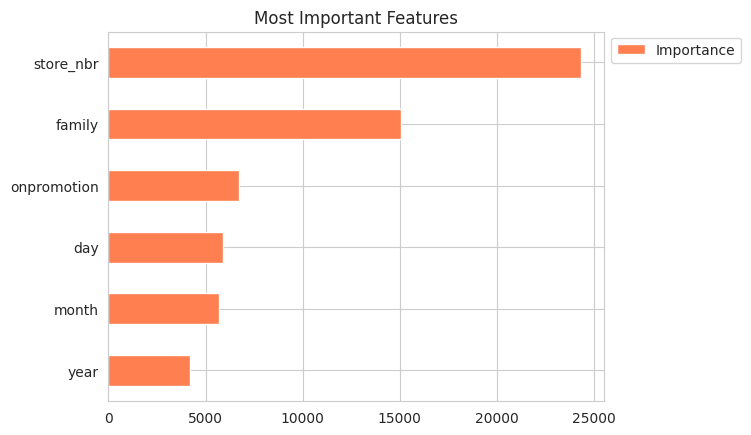

In [43]:
feature_importance.sort_values('Importance').plot(kind='barh', title='Most Important Features', color='coral')
plt.legend(loc='center left', bbox_to_anchor=(1, .95))
plt.show()

In [44]:
test['prediction']=model.predict(dtest)

In [45]:
score = np.sqrt(mean_squared_error(test['sales'], test['prediction']))
print(f'RMSE Score on test set: {score:0.5}')

RMSE Score on test set: 580.77


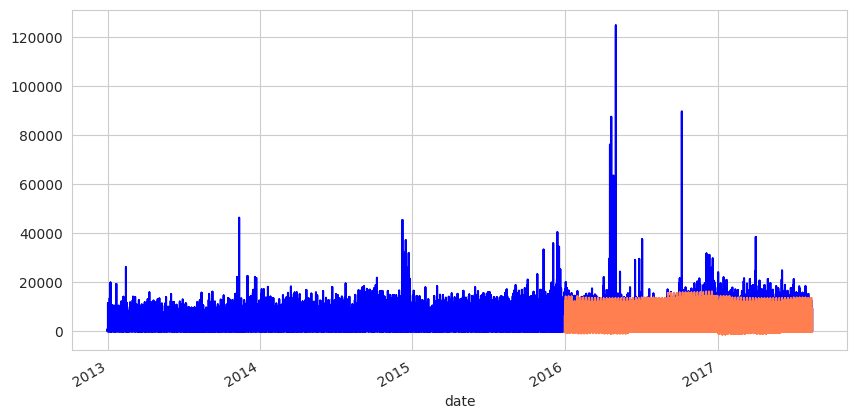

In [46]:
fig, ax = plt.subplots(figsize=(10,5))

df['sales'].plot(ax=ax, color='blue')
test['prediction'].plot(ax=ax, color='coral')

fig.show()

We can see that the prediction is flat, this can be due to many reasons. We are going to explore some possible fixes which are different tuning params and a different split. It would also be a good time to introduce the other datasets to capture relationships.

In [47]:
df_hol = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv')
df_hol['date'] = pd.to_datetime(df_hol['date'])
df_hol.set_index('date', inplace=True)

df_hol.head()

,type,locale,locale_name,description,transferred
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [48]:
df_hol.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 350 entries, 2012-03-02 to 2017-12-26
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   type         350 non-null    object
 1   locale       350 non-null    object
 2   locale_name  350 non-null    object
 3   description  350 non-null    object
 4   transferred  350 non-null    bool  
dtypes: bool(1), object(4)
memory usage: 14.0+ KB


In [49]:
df_hol.isna().sum()

type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

In [50]:
df_hol['description'].unique()

array(['Fundacion de Manta', 'Provincializacion de Cotopaxi',
       'Fundacion de Cuenca', 'Cantonizacion de Libertad',
       'Cantonizacion de Riobamba', 'Cantonizacion del Puyo',
       'Cantonizacion de Guaranda', 'Provincializacion de Imbabura',
       'Cantonizacion de Latacunga', 'Fundacion de Machala',
       'Fundacion de Santo Domingo', 'Cantonizacion de El Carmen',
       'Cantonizacion de Cayambe', 'Fundacion de Esmeraldas',
       'Primer Grito de Independencia', 'Fundacion de Riobamba',
       'Fundacion de Ambato', 'Fundacion de Ibarra',
       'Cantonizacion de Quevedo', 'Independencia de Guayaquil',
       'Traslado Independencia de Guayaquil', 'Dia de Difuntos',
       'Independencia de Cuenca', 'Provincializacion de Santo Domingo',
       'Provincializacion Santa Elena', 'Independencia de Guaranda',
       'Independencia de Latacunga', 'Independencia de Ambato',
       'Fundacion de Quito-1', 'Fundacion de Quito', 'Fundacion de Loja',
       'Navidad-4', 'Cantonizac

In [51]:
df_hol['type'].unique()

array(['Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event'],
      dtype=object)

In [52]:
df_hol['locale_name'].unique()

array(['Manta', 'Cotopaxi', 'Cuenca', 'Libertad', 'Riobamba', 'Puyo',
       'Guaranda', 'Imbabura', 'Latacunga', 'Machala', 'Santo Domingo',
       'El Carmen', 'Cayambe', 'Esmeraldas', 'Ecuador', 'Ambato',
       'Ibarra', 'Quevedo', 'Santo Domingo de los Tsachilas',
       'Santa Elena', 'Quito', 'Loja', 'Salinas', 'Guayaquil'],
      dtype=object)

In [53]:
df = df.merge(df_hol, left_index=True, right_index=True)
df_test = df_test.merge(df_hol, how='left', left_index=True, right_index=True)

df

,store_nbr,family,sales,onpromotion,day,month,quarter,year,type,locale,locale_name,description,transferred
date,,,,,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.000,0,1,1,1,2013,Holiday,National,Ecuador,Primer dia del ano,False
2013-01-01,1,BABY CARE,0.000,0,1,1,1,2013,Holiday,National,Ecuador,Primer dia del ano,False
2013-01-01,1,BEAUTY,0.000,0,1,1,1,2013,Holiday,National,Ecuador,Primer dia del ano,False
2013-01-01,1,BEVERAGES,0.000,0,1,1,1,2013,Holiday,National,Ecuador,Primer dia del ano,False
2013-01-01,1,BOOKS,0.000,0,1,1,1,2013,Holiday,National,Ecuador,Primer dia del ano,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-15,9,POULTRY,438.133,0,1,8,3,2017,Holiday,Local,Riobamba,Fundacion de Riobamba,False
2017-08-15,9,PREPARED FOODS,154.553,1,1,8,3,2017,Holiday,Local,Riobamba,Fundacion de Riobamba,False
2017-08-15,9,PRODUCE,2419.729,148,1,8,3,2017,Holiday,Local,Riobamba,Fundacion de Riobamba,False


In [54]:
df_oil = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv')
df_oil['date'] = pd.to_datetime(df_oil['date'])
df_oil.set_index('date', inplace=True)

df_oil.head()

,dcoilwtico
date,
2013-01-01,NaN
2013-01-02,93.14
2013-01-03,92.97
2013-01-04,93.12
2013-01-07,93.20


In [55]:
df_oil.isna().sum()

dcoilwtico    43
dtype: int64

In [56]:
imputer = KNNImputer()

df_oil = pd.DataFrame(imputer.fit_transform(df_oil), columns=df_oil.columns, index=df_oil.index)

df_oil

,dcoilwtico
date,
2013-01-01,67.714366
2013-01-02,93.140000
2013-01-03,92.970000
2013-01-04,93.120000
2013-01-07,93.200000
...,...
2017-08-25,47.650000
2017-08-28,46.400000
2017-08-29,46.460000


<Axes: title={'center': 'Oil Prices'}>

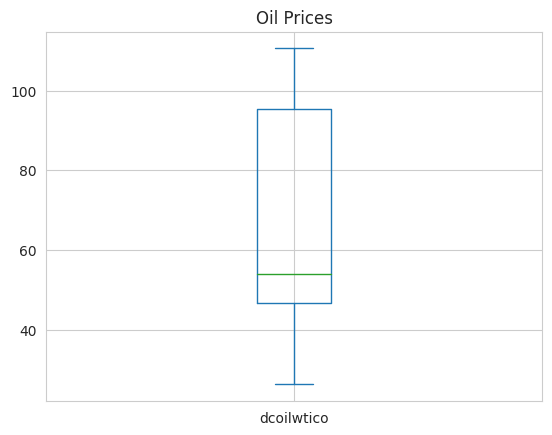

In [57]:
df_oil.plot(kind='box', title='Oil Prices')

In [58]:
df = df.merge(df_oil, left_index=True, right_index=True)
df_test = df_test.merge(df_oil, how='left', left_index=True, right_index=True)

df

,store_nbr,family,sales,onpromotion,day,month,quarter,year,type,locale,locale_name,description,transferred,dcoilwtico
date,,,,,,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.000,0,1,1,1,2013,Holiday,National,Ecuador,Primer dia del ano,False,67.714366
2013-01-01,1,BABY CARE,0.000,0,1,1,1,2013,Holiday,National,Ecuador,Primer dia del ano,False,67.714366
2013-01-01,1,BEAUTY,0.000,0,1,1,1,2013,Holiday,National,Ecuador,Primer dia del ano,False,67.714366
2013-01-01,1,BEVERAGES,0.000,0,1,1,1,2013,Holiday,National,Ecuador,Primer dia del ano,False,67.714366
2013-01-01,1,BOOKS,0.000,0,1,1,1,2013,Holiday,National,Ecuador,Primer dia del ano,False,67.714366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-15,9,POULTRY,438.133,0,1,8,3,2017,Holiday,Local,Riobamba,Fundacion de Riobamba,False,47.570000
2017-08-15,9,PREPARED FOODS,154.553,1,1,8,3,2017,Holiday,Local,Riobamba,Fundacion de Riobamba,False,47.570000
2017-08-15,9,PRODUCE,2419.729,148,1,8,3,2017,Holiday,Local,Riobamba,Fundacion de Riobamba,False,47.570000


In [59]:
df.columns

Index(['store_nbr', 'family', 'sales', 'onpromotion', 'day', 'month',
       'quarter', 'year', 'type', 'locale', 'locale_name', 'description',
       'transferred', 'dcoilwtico'],
      dtype='object')

In [61]:
encoder = OneHotEncoder()

encoded = encoder.fit_transform(df[['transferred']])

encoded_df = pd.DataFrame(encoded.toarray(), columns=encoder.get_feature_names_out())

encoded_df.index = df.index

df = pd.concat([df, encoded_df], axis=1)

df.drop('transferred', axis=1, inplace=True)

encoded = encoder.fit_transform(df_test[['transferred']])

encoded_df = pd.DataFrame(encoded.toarray(), columns=encoder.get_feature_names_out())

encoded_df.index = df_test.index

df_test = pd.concat([df_test, encoded_df], axis=1)

df_test.drop('transferred', axis=1, inplace=True)

df_test

,id,store_nbr,family,onpromotion,day,month,quarter,year,type,locale,locale_name,description,dcoilwtico,transferred_False,transferred_nan
date,,,,,,,,,,,,,,,
2017-08-16,3000888,1,AUTOMOTIVE,0,2,8,3,2017,NaN,NaN,NaN,NaN,46.80,0.0,1.0
2017-08-16,3000889,1,BABY CARE,0,2,8,3,2017,NaN,NaN,NaN,NaN,46.80,0.0,1.0
2017-08-16,3000890,1,BEAUTY,2,2,8,3,2017,NaN,NaN,NaN,NaN,46.80,0.0,1.0
2017-08-16,3000891,1,BEVERAGES,20,2,8,3,2017,NaN,NaN,NaN,NaN,46.80,0.0,1.0
2017-08-16,3000892,1,BOOKS,0,2,8,3,2017,NaN,NaN,NaN,NaN,46.80,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-31,3029395,9,POULTRY,1,3,8,3,2017,NaN,NaN,NaN,NaN,47.26,0.0,1.0
2017-08-31,3029396,9,PREPARED FOODS,0,3,8,3,2017,NaN,NaN,NaN,NaN,47.26,0.0,1.0
2017-08-31,3029397,9,PRODUCE,1,3,8,3,2017,NaN,NaN,NaN,NaN,47.26,0.0,1.0


In [62]:
df['transferred'] = df['transferred_True'].astype(int)  
df.drop(['transferred_True', 'transferred_False'], axis=1, inplace=True)

df_test['transferred'] = df_test['transferred_False']
df_test.drop(['transferred_False'], axis=1, inplace=True)

In [63]:
FEATURES = ['store_nbr', 'family', 'onpromotion', 'day', 'month','quarter', 'year', 'type', 'locale', 'locale_name', 'description', 'dcoilwtico', 'transferred']
CATEGORY = ['family','locale', 'locale_name', 'description', 'type']
NUMERIC = [feat for feat in FEATURES if feat not in CATEGORY]
TARGET = ['sales']

In [64]:
df = df.loc[df.sales > 0]

In [65]:
mean = df['sales'].mean()
std = df['sales'].std()

df = df[(df['sales'] > (mean - 3 * std)) & (df['sales'] < (mean + 3 * std))]

In [66]:
duplicates = df.duplicated()
print(duplicates.any())  # Prints True if there are any duplicates, False otherwise
print(duplicates.sum())  # Prints the number of duplicate rows


False
0


In [67]:
# df.to_csv('train_hpc_reduced.csv')

Run following code on HPC for best results, use best params for final model.

In [68]:
# X_train = df[FEATURES]
# y_train = df[TARGET]

# params = {
#     'xgb__n_estimators': [100,500,1000],
#     'xgb__learning_rate': [0.1, 0.01],
#     'xgb__max_depth': [3,6,10],
#     'xgb__min_child_weight': [1],
#     'xgb__subsample': [0.5,0.8,1.0],
#     'xgb__colsample_bytree': [0.8],
# }

# # Column transformer setup
# col_transformer = ColumnTransformer([
#     ('encoder', BinaryEncoder(), CATEGORY),
#     ('scaler', StandardScaler(), NUMERIC)
# ])

# # Pipeline setup
# pipeline = Pipeline(steps=[
#     ('preprocess', col_transformer),
#     ('xgb', xgb.XGBRegressor())
# ])

# grid_search = GridSearchCV(pipeline, param_grid=params, cv=5, n_jobs=-1, verbose=1)
# grid_search.fit(X_train, y_train)

# print(grid_search.best_params_)

With the best paramaters given by the GridSearch, we can train the model on the data with the appropriate parameters. I will also do this on the HPC since the dataset is so large. Then I will load it back for our final predictions


In [69]:
# X_train = df[FEATURES]
# y_train = df[TARGET]

# best_params = {
#     'colsample_bytree': 0.8, 
#     'learning_rate': 0.01, 
#     'max_depth': 6, 
#     'min_child_weight': 1, 
#     'n_estimators': 500, 
#     'subsample': 0.5
# }

# # Column transformer setup
# col_transformer = ColumnTransformer([
#     ('encoder', BinaryEncoder(), CATEGORY),
#     ('scaler', StandardScaler(), NUMERIC)
# ])

# # Pipeline setup
# pipeline = Pipeline(steps=[
#     ('preprocess', col_transformer),
#     ('xgb', xgb.XGBRegressor(**best_params))
# ])

# pipeline.fit(X_train, y_train)

# joblib.dump(pipeline, 'model.joblib')

In [70]:
model = joblib.load('/kaggle/input/timeseriesxgb/other/1.1/1/model.joblib')

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 1.3.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 1.3.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator ColumnTransformer from version 1.3.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For

In [72]:
preds = pd.DataFrame(model.predict(df_test.drop(['id'], axis=1)))

In [73]:
print(preds.shape, df_test.shape)

(28512, 1) (28512, 15)


In [74]:
df_test = pd.concat([df_test.reset_index(drop=True), preds.reset_index(drop=True)], axis=1)
df_test

,id,store_nbr,family,onpromotion,day,month,quarter,year,type,locale,locale_name,description,dcoilwtico,transferred_nan,transferred,0
0,3000888,1,AUTOMOTIVE,0,2,8,3,2017,NaN,NaN,NaN,NaN,46.80,1.0,0.0,125.930748
1,3000889,1,BABY CARE,0,2,8,3,2017,NaN,NaN,NaN,NaN,46.80,1.0,0.0,-16.115740
2,3000890,1,BEAUTY,2,2,8,3,2017,NaN,NaN,NaN,NaN,46.80,1.0,0.0,186.000870
3,3000891,1,BEVERAGES,20,2,8,3,2017,NaN,NaN,NaN,NaN,46.80,1.0,0.0,1884.431885
4,3000892,1,BOOKS,0,2,8,3,2017,NaN,NaN,NaN,NaN,46.80,1.0,0.0,-56.259727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28507,3029395,9,POULTRY,1,3,8,3,2017,NaN,NaN,NaN,NaN,47.26,1.0,0.0,457.493561
28508,3029396,9,PREPARED FOODS,0,3,8,3,2017,NaN,NaN,NaN,NaN,47.26,1.0,0.0,82.662086
28509,3029397,9,PRODUCE,1,3,8,3,2017,NaN,NaN,NaN,NaN,47.26,1.0,0.0,1153.546753
28510,3029398,9,SCHOOL AND OFFICE SUPPLIES,9,3,8,3,2017,NaN,NaN,NaN,NaN,47.26,1.0,0.0,784.544189


In [75]:
df_test.rename(columns={0:'sales'}, inplace=True)

df_test = df_test[['id', 'sales']]

df_test.to_csv('submission.csv', index=False)